In [1]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from aeon.io.reader import Reader, Csv
from dotmap import DotMap
import aeon.io.api as api
import os

root_folder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/'
root_folder_photometry = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/Photometry/2024_08_23-14_54_36/2024_08_23-14_54_36/'

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
photometry_reader = utils.PhotometryReader("Fluorescence")
video_reader = utils.Video("VideoData1")
onix_digital_reader = utils.TimestampedCsvReader("OnixDigital", columns=["Buttons", "Links", "Port", "Clock", "HubSyncCounter"])

h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH1/'
h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH2/'

In [87]:
# read experiment metadata
session_settings = utils.load(session_data_reader, root_folder)

print(session_settings.iloc[0]['metadata'].blocks[1].haltProtocol)

DotMap(randomDelay=0.0, minumumDelay=1.0, haltTime=1.0, haltGain=1.0)


In [3]:
# read harp streams, experiment events, video
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
camera_triggers = utils.load_harp(h1_reader.Cam0Event, h1_datafolder)
immediate_pulses = utils.load_harp(h2_reader.ImmediatePulses, h2_datafolder)
analog_input = utils.load_harp(h2_reader.AnalogInput, h2_datafolder)
experiment_events = utils.load(experiment_events_reader, root_folder)
video_data = utils.load(video_reader, root_folder)

                                                 Event        Seconds
Time                                                                 
1904-01-06 01:46:48.540256         Sync signal started  438408.540256
1904-01-06 01:47:05.810240  LinearNormal block started  438425.810240
1904-01-06 01:47:05.898144             Homing platform  438425.898144
1904-01-06 01:47:06.470240   Wait for run threshold...  438426.470240
1904-01-06 01:47:27.930688      Check halt probability  438447.930688
...                                                ...            ...
1904-01-06 02:18:30.220256      Check halt probability  440310.220256
1904-01-06 02:18:30.220256              Halt delay: 1s  440310.220256
1904-01-06 02:18:31.240256              Apply halt: 1s  440311.240256
1904-01-06 02:18:32.290240   Wait for run threshold...  440312.290240
1904-01-06 02:18:33.970240         Block timer elapsed  440313.970240

[1240 rows x 2 columns]


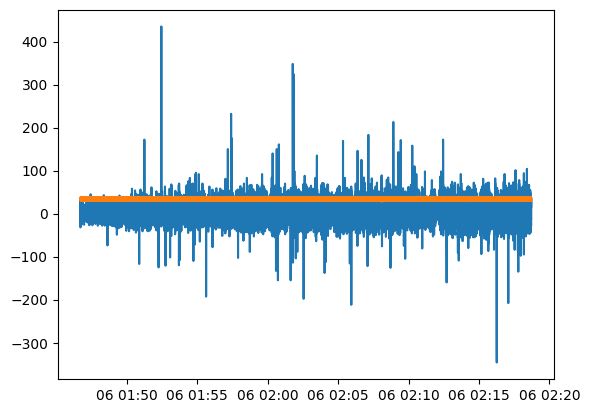

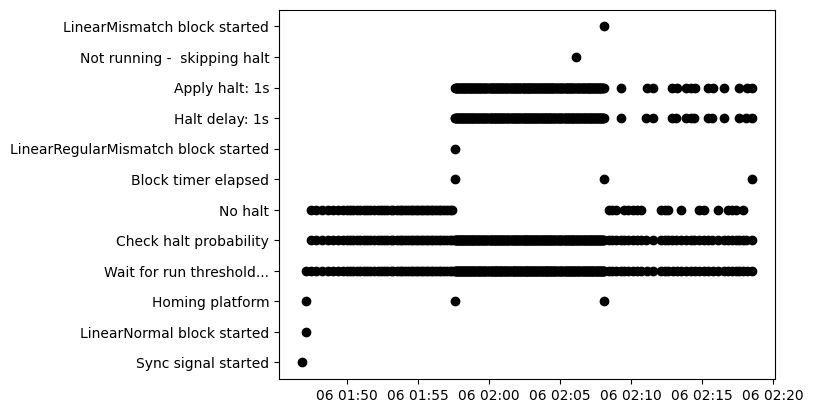

In [4]:
print(experiment_events)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0Y'])
plt.plot(analog_input['AnalogInput'])

plt.figure()
plt.scatter(experiment_events.index, experiment_events["Event"], c='k')

In [5]:
# read onix streams
# stream assigns a harp timestamp to each analog block
analog_frame_count = utils.load(framecount_reader, root_folder)

# load onix digital data
digital_data = utils.load(onix_digital_reader, root_folder)

# directly read an onix analog data / clock bin file
analog_data = utils.read_onix_analog_data(root_folder, "OnixAnalogData", np.int16)
analog_clock = utils.read_onix_analog_clock(root_folder, "OnixAnalogClock", np.uint64)

# confirm relationship between data, clock and frame count
print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])

191726100 191726100 1917261


C:\Users\neurogears\AppData\Local\Temp\ipykernel_24824\3512339978.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(analog_data.shape[0], analog_clock.shape[0], analog_frame_count["Index"][-1])


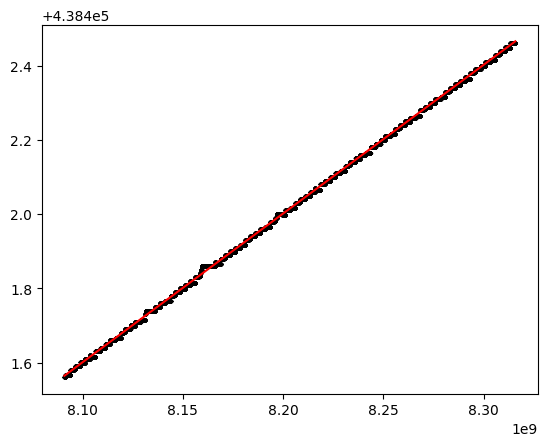

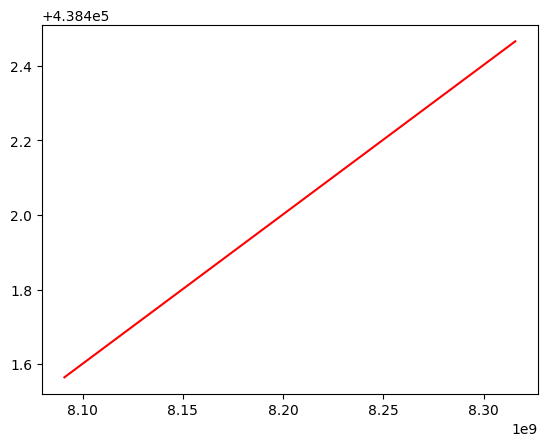

In [43]:
# find time mapping/warping between onix and harp clock
upsample = np.array(analog_frame_count["Seconds"]).repeat(100, axis=0)[0:-100]

# define conversion functions between timestamps (onix to harp)
o_m, o_b = np.polyfit(analog_clock, upsample, 1)
onix_to_harp_seconds = lambda x: x*o_m + o_b
onix_to_harp_timestamp = lambda x: api.aeon(onix_to_harp_seconds(x))
harp_to_onix_clock = lambda x: (x - o_b) / o_m

window = range(10000, 100000)
plt.figure()
plt.scatter(analog_clock[window], upsample[window], c='k', s=2)
plt.plot(analog_clock[window], onix_to_harp_seconds(analog_clock[window]), c='r')

plt.figure()
plt.plot(analog_clock[window], onix_to_harp_seconds(analog_clock[window]), c='r')

In [44]:
print(analog_clock[1])
print(m)
print(onix_to_harp_seconds(analog_clock[1]))

8065858258
249545.92881274002
438401.4643343909


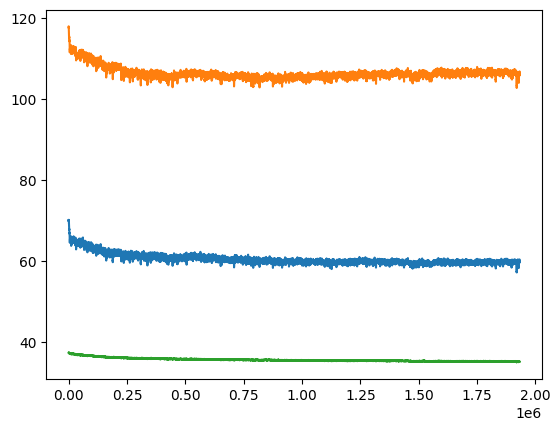

In [39]:
# read photometry stream
photometry = utils.load_photometry(photometry_reader, root_folder_photometry)

plt.figure()
plt.plot(photometry[0]["CH1-410"])
plt.plot(photometry[0]["CH1-470"])
plt.plot(photometry[0]["CH1-560"])

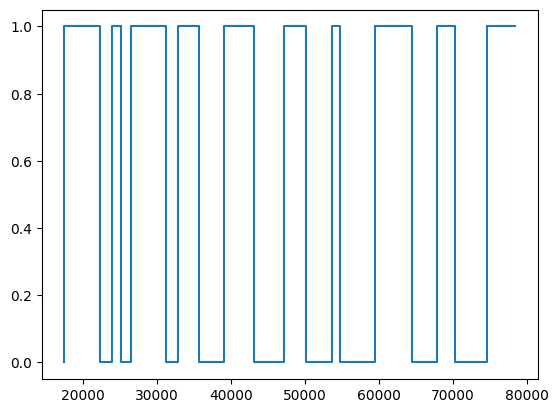

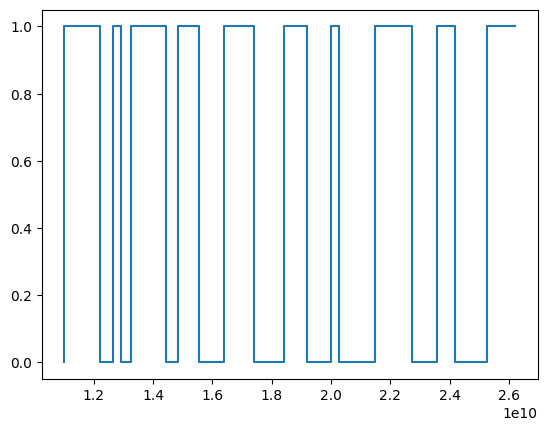

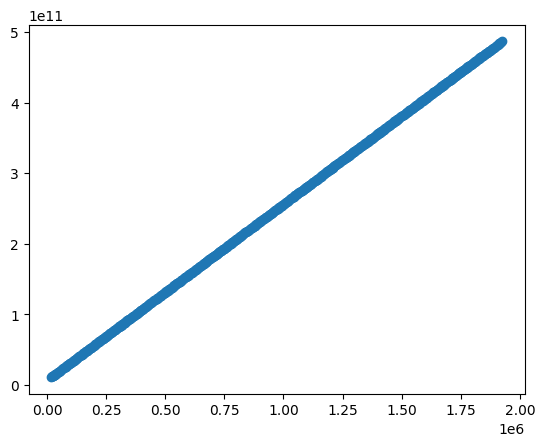

In [93]:
# photometry sync example
# binarise photometry input events
photometry_sync_events = photometry[0]["Events"]
photometry_sync_events = photometry_sync_events[~photometry_sync_events.isna()] # Restrict to events
photometry_sync_events = photometry_sync_events.transform(lambda x: int(x.split('*')[2])) # Extract channel value

# extract corresponding events in onix
digital_data["_sync_line"] = 1 - digital_data["Port"] & 1

window = range(0, 20)
plt.figure()
plt.step(photometry_sync_events.index[window], photometry_sync_events.values[window])

plt.figure()
plt.step(digital_data.iloc[window]["Clock"], digital_data.iloc[window]["_sync_line"])

plt.figure()
plt.scatter(photometry_sync_events.index, digital_data["Clock"])

# define conversion functions between timestamps (onix to harp)
m, b = np.polyfit(photometry_sync_events.index, digital_data["Clock"], 1)
photometry_to_onix_time = lambda x: x*m + b
photometry_to_harp_time = lambda x: onix_to_harp_timestamp(photometry_to_onix_time(x))
onix_time_to_photometry = lambda x: (x - b) / m

                                                          Event        Seconds
Time                                                                          
1904-01-06 01:57:35.640256  LinearRegularMismatch block started  439055.640256


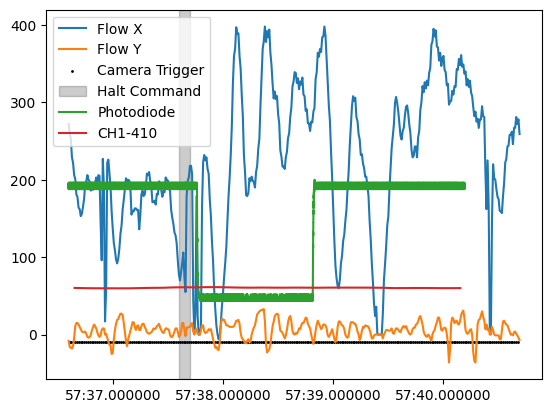

In [111]:
# example, see harp data, experiment events, onix data for a given window, synchronised.
# where did the LinearRegularMismatch block start (approximately)?
block_start = experiment_events[experiment_events["Event"].eq("LinearRegularMismatch block started")]
print(block_start)

# Get the first 20 halt times after this block started
block_halts = experiment_events[(experiment_events["Event"].eq("Apply halt: 1s")) & (experiment_events.index > block_start.index[0])].iloc[0:20]

# Plot flow sensor and camera triggers during given halt period
idx = 0
sec_start = block_halts.index[idx]
sec_stop = block_halts.index[idx+1]
min_time = sec_start - pd.DateOffset(seconds=1)
max_time = sec_stop + pd.DateOffset(seconds=0.5)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0X'][min_time:max_time], label='Flow X')
plt.plot(flow_sensor['OpticalTrackingRead0Y'][min_time:max_time], label='Flow Y')
plt.scatter(camera_triggers[min_time:max_time].index, np.ones((1, len(camera_triggers[min_time:max_time]))) * -10, s=1, c='k', label='Camera Trigger')
plt.axvspan(sec_start, sec_start + pd.DateOffset(seconds=0.1), color='black', alpha=0.2, label='Halt Command')

# overlay the onix photodiode signal in converted time
onix_sec_start_time = harp_to_onix_clock(block_halts.iloc[idx]["Seconds"] - 1)
onix_sec_start_index = np.where(analog_clock >= onix_sec_start_time)[0][0]

onix_sec_stop_time = harp_to_onix_clock(block_halts.iloc[idx+1]["Seconds"])
onix_sec_stop_index = np.where(analog_clock >= onix_sec_stop_time)[0][0]
plt.plot(onix_to_harp_timestamp(analog_clock[onix_sec_start_index:onix_sec_stop_index]), analog_data[onix_sec_start_index:onix_sec_stop_index, 0], label='Photodiode')

# overlay photometry
photometry_sec_start_time = onix_time_to_photometry(onix_sec_start_time)
photometry_sec_stop_time = onix_time_to_photometry(onix_sec_stop_time)
photometry_sec = photometry[0].loc[(photometry[0].index >= photometry_sec_start_time) & (photometry[0].index <= photometry_sec_stop_time)]

plt.plot(photometry_to_harp_time(photometry_sec.index), photometry_sec['CH1-410'], label='CH1-410')

plt.legend()